In [1]:
import os
import cv2 as cv
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import normalize
from tqdm import tqdm
from glob import glob
from Unet import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, TensorBoard
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau



In [2]:
root = 'D:/Work/Retinopathy/eye dataset/Retina vessel/full data/'
image_directory = os.path.join(root, 'images/')
mask_directory = os.path.join(root , 'gt/')

In [3]:
print(image_directory)
print(mask_directory)

D:/Work/Retinopathy/eye dataset/Retina vessel/full data/images/
D:/Work/Retinopathy/eye dataset/Retina vessel/full data/gt/


In [4]:
image_dataset = []  
mask_dataset = []  
SIZE = 256
images = os.listdir(image_directory)
for i, image_name in tqdm(enumerate(images)):    
    if (image_name.split('.')[1] == 'png' or 'TIF'):
        image = cv.imread(image_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))



masks = os.listdir(mask_directory)
for i, image_name in tqdm(enumerate(masks)):
    if (image_name.split('.')[1] == 'png'):
        image = cv.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))

712it [03:04,  3.86it/s]
712it [01:10, 10.04it/s]


In [5]:
print(len(image_dataset))
print(len(mask_dataset))

712
712


In [6]:

image_dataset_uint8=np.array(image_dataset)
mask_dataset_uint8=np.array(mask_dataset)

In [7]:
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)

mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.


In [8]:
image_train, image_test, mask_train, mask_test = train_test_split(image_dataset,
                                                                  mask_dataset,
                                                                  test_size = 0.10,
                                                                  random_state = 0)

print(len(image_train))
print(len(image_test))

640
72


In [9]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [10]:
batch_size = 5

callbacks = [
        EarlyStopping(patience=10, monitor='val_loss', mode = 'min'),
        TensorBoard(log_dir='logs')]

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=5, min_lr=0.0001)

model_checkpoint = ModelCheckpoint('vessel_unet_checkpoints.hdf5',
                                    monitor = 'val_accuracy',
                                    verbose = 1,
                                    save_best_only= True,
                                    mode= 'max')


history = model.fit(image_train,
                        mask_train,
                        batch_size= batch_size,
                        steps_per_epoch= np.ceil(len(image_train)//batch_size),
                        epochs = 50, 
                        validation_steps= np.ceil(len(image_test)//batch_size),     
                        validation_data = (image_test, mask_test),
                        callbacks=(reduce_lr,model_checkpoint)
                             )
print('Model Trained')


Epoch 1/50
128/128 [==============================] - 233s 712ms/step - loss: 0.3224 - accuracy: 0.8087 - val_loss: 0.2865 - val_accuracy: 0.8054

Epoch 00001: val_accuracy improved from -inf to 0.80537, saving model to vessel_unet_checkpoints.hdf5
Epoch 2/50
128/128 [==============================] - 98s 762ms/step - loss: 0.2819 - accuracy: 0.8090 - val_loss: 0.2828 - val_accuracy: 0.8054

Epoch 00002: val_accuracy did not improve from 0.80537
Epoch 3/50
128/128 [==============================] - 102s 799ms/step - loss: 0.2772 - accuracy: 0.8090 - val_loss: 0.2786 - val_accuracy: 0.8054

Epoch 00003: val_accuracy did not improve from 0.80537
Epoch 4/50
128/128 [==============================] - 103s 810ms/step - loss: 0.2346 - accuracy: 0.8144 - val_loss: 0.2123 - val_accuracy: 0.8192

Epoch 00004: val_accuracy improved from 0.80537 to 0.81916, saving model to vessel_unet_checkpoints.hdf5
Epoch 5/50
128/128 [==============================] - 127s 993ms/step - loss: 0.1993 - accuracy:

In [11]:
model.save('vessel_seg.h5')

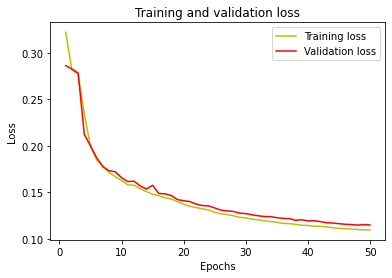

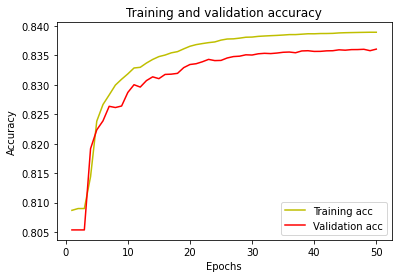

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [9]:
model = load_model('vessel_seg.h5')


In [10]:
pred = model.predict(image_test)
pred_thresholded = pred > 0.5

In [11]:
intersection = np.logical_and(mask_test, pred_thresholded)
union = np.logical_or(mask_test, pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.42193012318320494
